In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import skimage

%matplotlib inline

%load_ext autoreload

%autoreload 2

In [2]:
model = torchvision.models.vgg16(pretrained=True).eval()
sumie.utils.remove_inplace(model)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

100%|██████████| 1000/1000 [01:45<00:00,  9.52it/s]


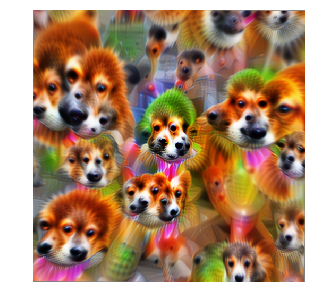

In [8]:
class ProgressiveShift(torch.nn.Module):

    def __init__(self):
        super(ProgressiveShift, self).__init__()
        self.amount = 0
        
    def forward(self, image):
        self.amount += 1
        return image.roll(self.amount, 2)
    
class GradientMask(torch.nn.Module):

    def __init__(self):
        super(GradientMask, self).__init__()
        self.register_backward_hook(self.hook)
        
    def forward(self, image):
        return image
    
    def hook(self, module, grad_input, grad_output):
        modified = torch.zeros(grad_input[0].size()).cuda()
        modified[:,:,:100,:100] = grad_input[0][:,:,:100,:100]
        return (modified,)


def scale_image(i, image, model, objective, opt):
    if i % 2 == 0:
        scaled = torch.nn.functional.interpolate(image.base_image.pixels.data, scale_factor=1.005, mode='bilinear', align_corners=False)
        original_size = image.base_image.pixels.size()
        image.base_image.pixels.data = scaled[:original_size[0],:original_size[1],:original_size[2],:original_size[3]]

def grab_value(a):
    return a[5, 5]
        
def change_objective(i, image, model, objective, opt):
    if i % 100 == 0:
        opt.objective = sumie.objectives.ConvChannel(model[26], np.random.randint(512), func=torch.std)

def change_combined(opt, i):
    if i % 400 == 0:
        opt.objective.children[0] = sumie.objectives.ConvChannel(opt.model[26], np.random.randint(512), func=torch.std)
    if i % 300 == 0:
        opt.objective.children[1] = sumie.objectives.ConvChannel(opt.model[10], np.random.randint(256), func=torch.std)

from skimage.transform import AffineTransform

def warp_image(opt, i):
    if i % 5 == 0:
        s_x = 1/1.01
        s_y = 1/1.01
        x = 512/2
        y = 512/2
        matrix = np.array([[s_x,  0, (-s_x*x)+x],
                            [0,  s_y, (-s_y*y)+y],
                            [0,    0,          1]])
        tform = AffineTransform(matrix=matrix)
        reshaped_image = opt.image.base_image().detach().permute(3,2,1,0).squeeze(3).cpu().numpy()
        warped = skimage.transform.warp(reshaped_image, tform)
        warped = skimage.transform.rotate(warped, 0.25)
        #warped = reshaped_image
        warped = torch.Tensor(warped).permute(2,1,0).unsqueeze(0).contiguous()
        opt.image.base_image.set_pixels(warped.to(device))

imsize = 512
content_url = 'https://upload.wikimedia.org/wikipedia/commons/6/69/Phoenix_Hall%2C_Byodo-in%2C_November_2016_-01.jpg'
content_image = sumie.io.load_url(content_url, size=(imsize, imsize))

im = sumie.Image((512, 512), param='fft', transforms=[
                    sumie.transforms.PositionJitter(8),
                    sumie.transforms.Interpolate(0.5),
                    sumie.transforms.Normalise(),
              ], init=content_image
            )

device = 'cuda'
im.to(device)
model.to(device)
channel = sumie.objectives.ConvChannel(model.features[26], 0, func=torch.std)
obj2 = sumie.objectives.ConvChannel(model.features[10], 0, func=torch.std)
combined = sumie.objectives.Composite([channel, obj2], [1, 5])
opt = sumie.Optimiser(im, model.features, sumie.objectives.DeepDream(model.features[23]))
opt.add_callback(warp_image)
#opt.add_callback(change_combined)

opt.run(iterations=1000, progress=True, lr=0.025, output='tmp', output_skip=5)
sumie.vis.show(im.get_image())

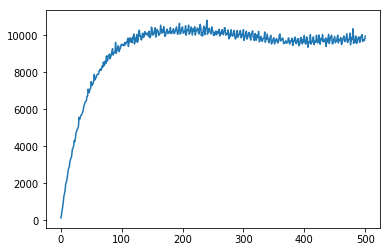

In [4]:
plt.plot([x.item() for x in opt.history])

In [5]:
for child in opt.objective.children:
    print(child.objective)


AttributeError: 'DeepDream' object has no attribute 'children'